# Quest10: 폐렴아 기다려라!

### 평가문항에 맞춰서 작성
**1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.**  
-> 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

**2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.**  
-> regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.

**3. ResNet 모델을 구현 하였다**  
-> Resnet 의 Residual block을 구현하고 학습의 경우 1에폭만 진행하여도 인정

---

# <span style="background-color:#E6E6FA"> Step 1. 실험환경 Set-up </span>

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

---

# <span style="background-color:#E6E6FA"> Step 2. 데이터 준비하기 </span>

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 1

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0485-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1082
Pneumonia images count in training set: 3103


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


augment 적용

In [14]:
def augment(image,label):
    # image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    # 50% 확률로 상하 뒤집기
    image = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='vertical')(image)
    # 50% 확률로 랜덤 회전 (0도에서 180도 범위)
    image = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.5, fill_mode='reflect')(image)
    
    return image,label

In [15]:
# 적용 여부를 추가하여 실험 False, True
def prepare_for_training(ds, augment_yn, shuffle_buffer_size=1000):
    if augment_yn:
        ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds,True)
val_ds = prepare_for_training(val_ds, True)

---

# <span style="background-color:#E6E6FA"> Step 3. 데이터 시각화 </span>

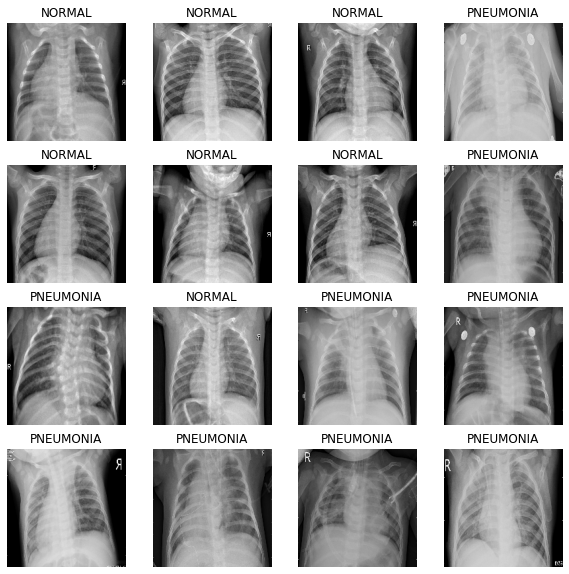

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())



---

# <span style="background-color:#E6E6FA"> Step 4-1. CNN 구현 </span>

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

---

# <span style="background-color:#E6E6FA"> Step 5. 데이터 imbalance 처리 </span>

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


---

# <span style="background-color:#E6E6FA"> Step 6-1. CNN 모델 훈련 </span>

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/9
261/261 [==============================] - 67s 206ms/step - loss: 0.3883 - accuracy: 0.8142 - precision: 0.9507 - recall: 0.7904 - val_loss: 0.6584 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 2/9
261/261 [==============================] - 53s 204ms/step - loss: 0.2397 - accuracy: 0.9100 - precision: 0.9696 - recall: 0.9069 - val_loss: 1.7825 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/9
261/261 [==============================] - 54s 208ms/step - loss: 0.1957 - accuracy: 0.9250 - precision: 0.9784 - recall: 0.9193 - val_loss: 0.4048 - val_accuracy: 0.8346 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 4/9
261/261 [==============================] - 54s 207ms/step - loss: 0.1829 - accuracy: 0.9306 - precision: 0.9740 - recall: 0.9312 - val_loss: 0.1133 - val_accuracy: 0.9606 - val_precision: 0.9829 - val_recall: 0.9638
Epoch 5/9
261/261 [==============================] - 57s 217ms/step - loss: 0.1715 - accuracy: 0

---

# <span style="background-color:#E6E6FA"> Step 7. CNN 결과 확인과 시각화 </span>

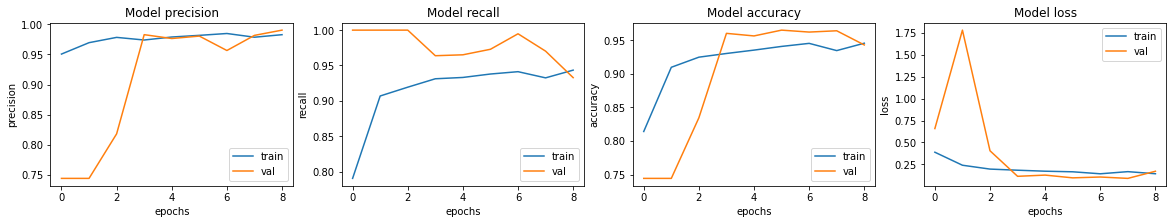

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 117ms/step - loss: 0.5684 - accuracy: 0.8446 - precision: 0.8263 - recall: 0.9513
Loss: 0.5684025883674622,
Accuracy: 0.8445512652397156,
Precision: 0.8262805938720703,
Recall: 0.9512820243835449


---

# <span style="background-color:#E6E6FA"> Step 4-2. ResNet-18 구현 </span>

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense

def residual_block(x, filters, stride=1):
    # 첫 번째 컨볼루션 레이어
    x_shortcut = x
    x = Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 두 번째 컨볼루션 레이어
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Residual 연결
    if stride != 1 or x.shape[-1] != x_shortcut.shape[-1]:
        x_shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='valid')(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = ReLU()(x)

    return x

def build_resnet18_model(input_shape=(180, 180, 3), num_classes=1):
    input_layer = Input(shape=input_shape)

    # 첫 번째 레이어
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual Block 반복
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Dense(units=num_classes, activation='sigmoid')(x)

    # 모델 정의
    model = tf.keras.Model(inputs=input_layer, outputs=x)

    return model

# 모델 생성
resnet18_model = build_resnet18_model()

# 모델 요약
resnet18_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 90, 90, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 90, 90, 64)   256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 90, 90, 64)   0           batch_normalization_7[0][0]      
______________________________________________________________________________________________

---

# <span style="background-color:#E6E6FA"> Step 6-2. RasNet 모델 훈련 </span>

In [26]:
with tf.device('/GPU:0'):
    model = build_resnet18_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/9
261/261 [==============================] - 63s 201ms/step - loss: 0.3244 - accuracy: 0.8836 - precision: 0.9573 - recall: 0.8824 - val_loss: 3.2862 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/9
261/261 [==============================] - 52s 200ms/step - loss: 0.2024 - accuracy: 0.9239 - precision: 0.9734 - recall: 0.9225 - val_loss: 0.3817 - val_accuracy: 0.8423 - val_precision: 0.9693 - val_recall: 0.8142
Epoch 3/9
261/261 [==============================] - 52s 201ms/step - loss: 0.1554 - accuracy: 0.9394 - precision: 0.9804 - recall: 0.9370 - val_loss: 1.1602 - val_accuracy: 0.5731 - val_precision: 0.9970 - val_recall: 0.4276
Epoch 4/9
261/261 [==============================] - 54s 206ms/step - loss: 0.1341 - accuracy: 0.9452 - precision: 0.9832 - recall: 0.9423 - val_loss: 0.3843 - val_accuracy: 0.8558 - val_precision: 0.9617 - val_recall: 0.8402
Epoch 5/9
261/261 [==============================] - 53s 205ms/step - loss: 0.1277 - accuracy: 0

---

# <span style="background-color:#E6E6FA"> Step 7-2. RasNet 결과 확인과 시각화 </span>

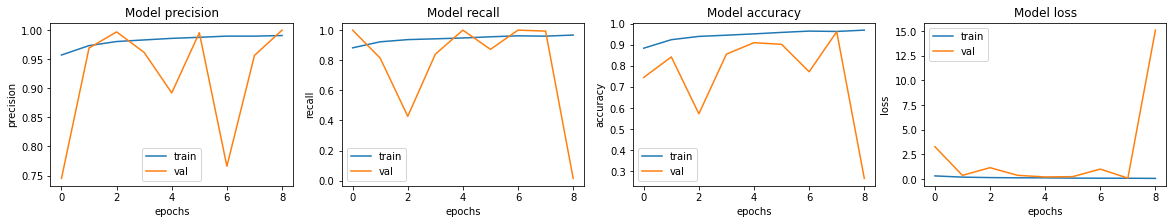

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 12.1598 - accuracy: 0.3862 - precision: 1.0000 - recall: 0.0179
Loss: 12.159770011901855,
Accuracy: 0.38621795177459717,
Precision: 1.0,
Recall: 0.01794871874153614


# 프로젝트 결과

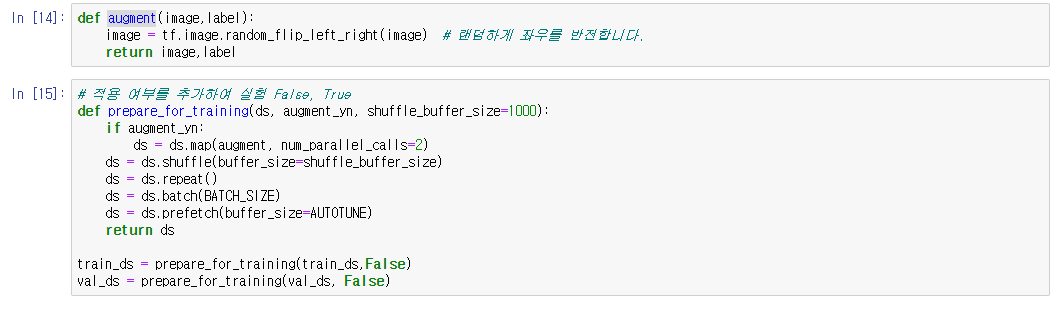

## augment 적용: False & Epoch: 9 - 그래프

- CNN

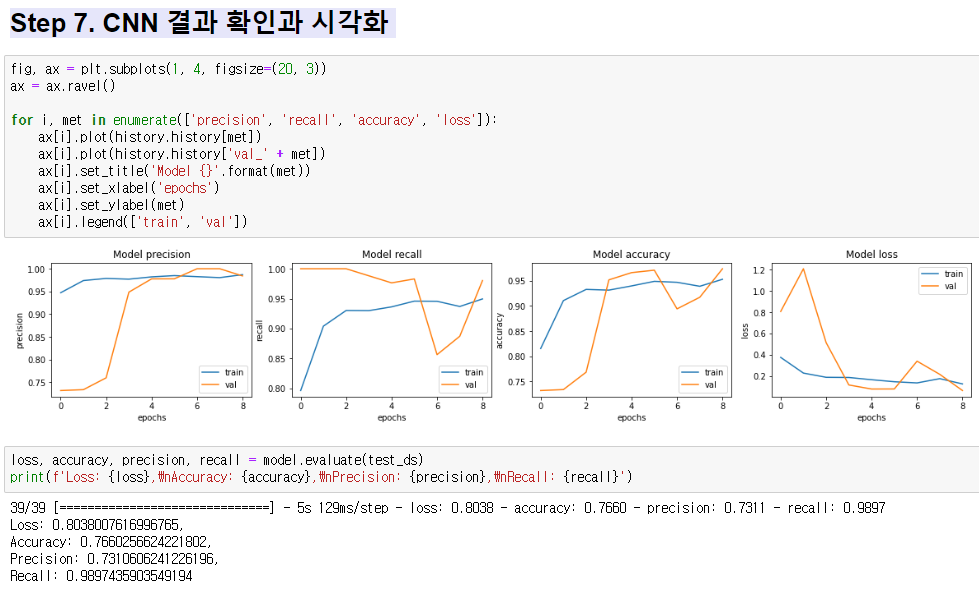

---

- RasNet

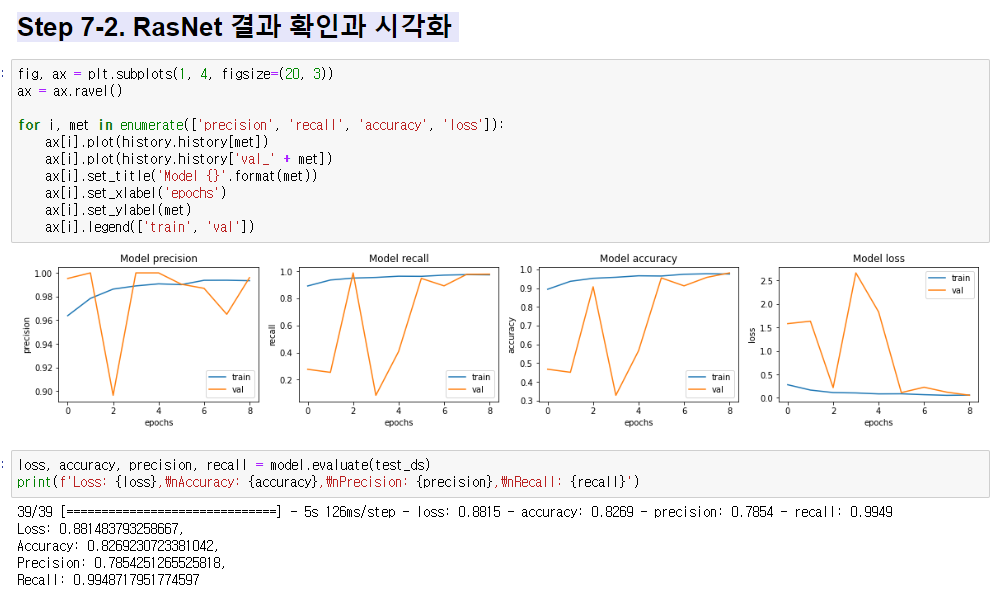

---


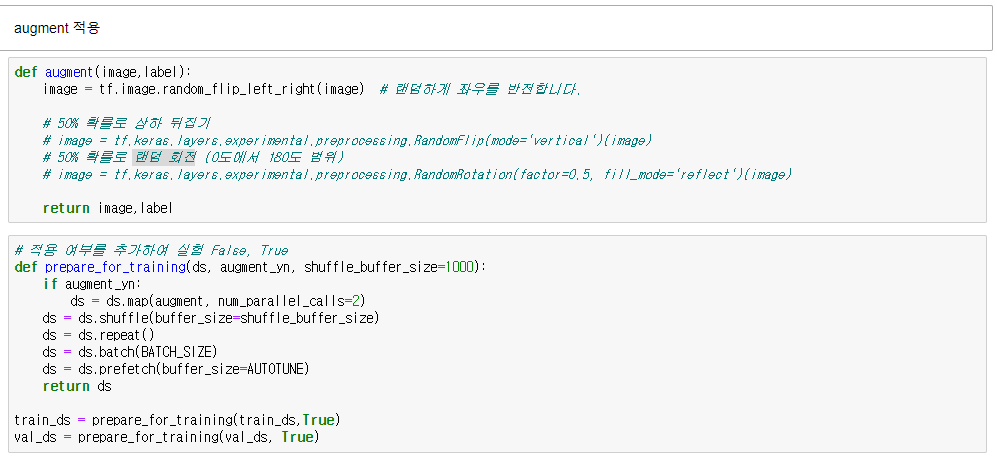

## augment 적용: True(좌우 반전) & Epoch: 9

- CNN

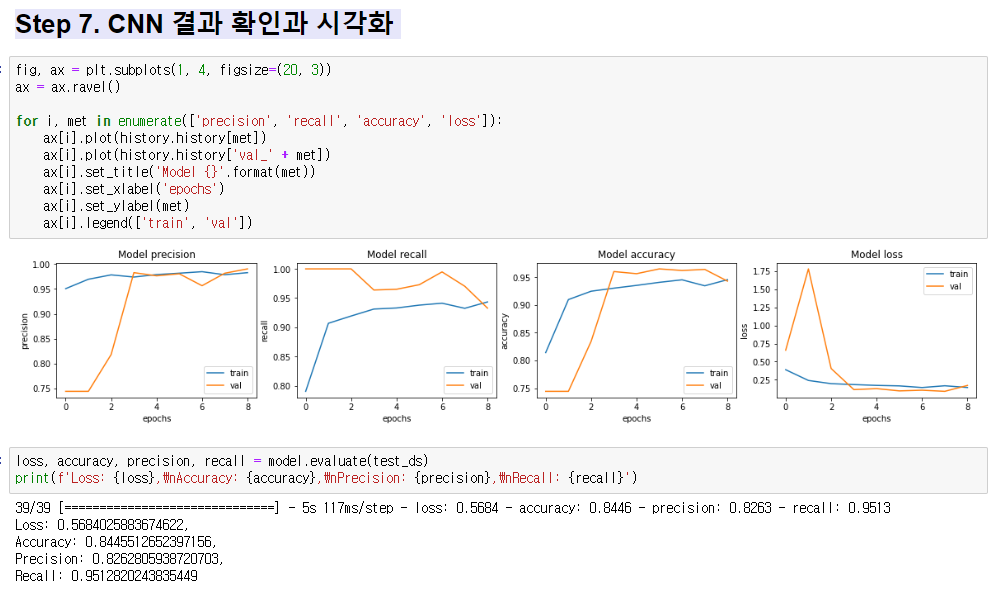

---

- RasNet

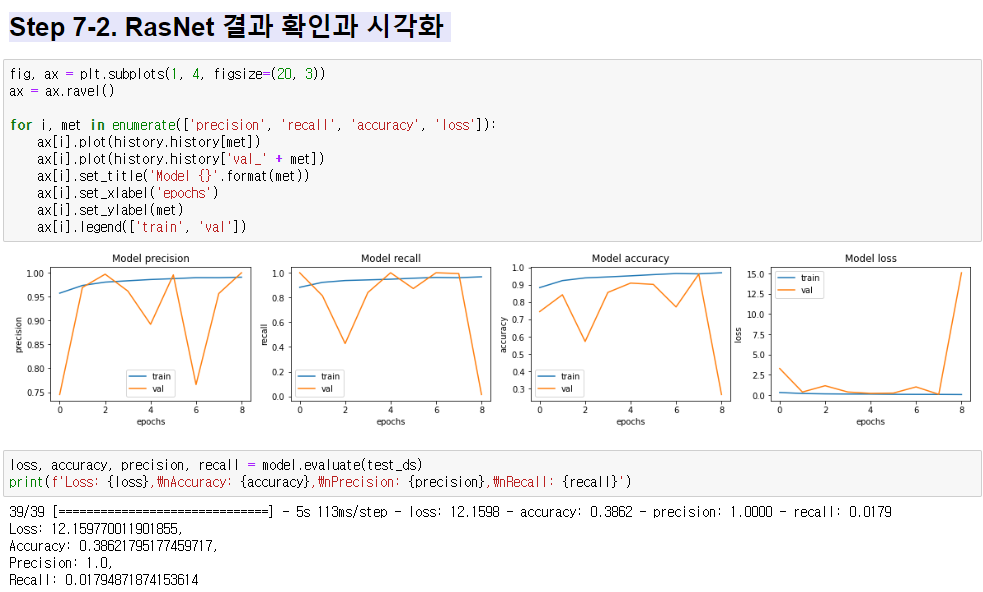

---

## 결과 비교

- 그래프 차이: 그래프를 봤을 떄 CNN이 loss가 안정적으로 떨어지는 모습을 보인다.  

- 분석: 확실히 augment를 추가했을 때 loss값이 튀는 부분에서 더 조금 올라간 것을 볼 수 있는데 좌우 반전은 noise이지만 긍정적으로 반영되는 정도라고 볼 수 있을 것 같다. 그래도 CNN이 제일 안정적인 그래프를 보여주는 것 같다.

--- 

 
# 추가로 실험! - 시간 이슈.. 로 Epoch 1

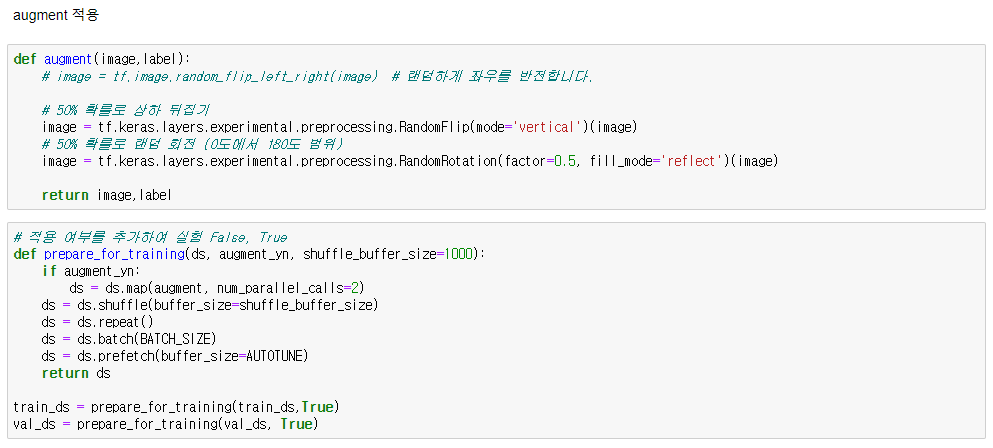

## augment 적용: False(상하 반전, 랜덤 회전, ) & Epoch: 1

- CNN


- RasNet

---


## augment 적용: True(상하 반전, 랜덤 회전) & Epoch: 1

- CNN


- RasNet

---

# 회고

이번 프로젝트는 폐렴 환자의 사진을 구분하는 모델을 만들어 보았는데 CNN, RasNET을 사용했는데, 
노드에서 공부한 CNN을 사용해서 한 결과가 더 좋아보인다.

augment를 적용하는 과정에서 noise가 생겨서 더 결과가 안좋아질 수도 있다고 해서 상하 반전과 회전을 추가해 보았다.
-> 시간이 더 있었으면 좋았을 것 같다..ㅠ 나중에 해봐야징..

힘들었던 점: RasNet이 적용이 잘 안되서 이것저것 찾아보았는데 residual_block의 경우에는 거의 기본적인 구조로 같았고,
model쪽에서 retrun을 model로 하지 않아서 수정했더니 성공했다.
    
어려운 점: 데이터 분석, 처리하는 부분에 대해서 뭘 더 해야할지 모르겠다.. 더 공부해봐야겠다.